In [ ]:
# G. Hayes 2024
# This script is used to analyse the ramp PETCO2 data and TCD data and plot TCD MCA mean velocity as a function of ETCO2 for the analysis presented in:
# G. Hayes, S. Sparks, J. Pinto, and D. P. Bulte, “Ramp protocol for non-linear cerebrovascular reactivity with transcranial doppler ultrasound,” Journal of Neuroscience Methods, vol. 416, p. 110381, Apr. 2025, doi: 10.1016/j.jneumeth.2025.110381.

# To run a batch of this script, use the "tcd_ramp_preproc_execute.sh" script.
# To run the fitting of the data after ther preprocessing, use the "2_tcd_ramp_fitting.ipynb" script.

# Updated this script for your purposes, notably:
# - the data folder name
# - the data file name
# - the output file name
# - alter parameters that may differ for your data

# It should be noted that channel 1 of the pwl data is the CO2, channel 2 is the O2 data, channel 3 is the raw TCD data, channel 4 is the PPG data, and channel 5 is the comment data.

In [ ]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import scipy as sp
from scipy.fft import fft, ifft
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
import ramp_cvr_functions as cvr_func
import copy
import csv

# Set TCD calibration factor (determined from DWL Dopler BoxX manual) and cut-off threshold (erroneous TCD values are set to NaN if below threshold)
QL_scale_max = 202 # QL scale maximum in cm/s
## DELETE TCD_calibration_factor = QL_scale_max*2/2.5 # **OLD** TCD calibration factor in cm/s/V
TCD_calibration_factor = 202.07 # TCD calibration factor in cm/s/V
print('TCD calibration factor (cm/s/V):', TCD_calibration_factor)
TCD_threshold = 0.07*TCD_calibration_factor # TCD threshold in cm/s
print('TCD threshold (cm/s):', TCD_threshold)
O2_height = -20 # O2 valley 'height' for peak detection in %

TCD calibration factor (cm/s/V): 202.07
TCD threshold (cm/s): 14.144900000000002


In [ ]:
local = 'path/to/data/'

In [ ]:
# PARAMETERS FOR BATCH ANALYSIS

filename = ""
O2prominence = ""
comment_start = ""
comment_end = ""
P_oxford = ""
man_shift = ""
peak_dif_thresh = ""

In [ ]:
# IF NOT USING THE BATCH SCRIPT, UNCOMMENT THE LINES AND RUN FOR EACH SUBJECT

# SUB-001
# filename = 'sub-001_ses-01_dat-YYYYMMDD_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 7
# peak_dif_thresh = 0.9 #% difference between PETCO2 peaks
# P_oxford = 1010.4 # hPa aka mbar (Oxford)

# SUB-002
# filename = 'sub-002_ses-01_dat-YYYYMMDD_task-ramp_pwl.txt'
# O2prominence = 0.5
# comment_start = 0
# comment_end = 8
# man_shift=-1800
# peak_dif_thresh = 0.9 #% difference between PETCO2 peaks
# P_oxford = 1015.4 # hPa aka mbar (Oxford)


/Users/ghayes/Desktop/Ramp_PWL/new_sub-002_ses-01_dat-20230816_task-ramp_pwl.txt


In [ ]:
P_conversion_perc2mmHg = P_oxford*(0.75006157584566)/100 # conversion factor from % gas concentration to mmHg
filepath = local + filename
print(filepath)

In [4]:
# Read text file into pandas DataFrame
cols = pd.read_csv(filepath, sep='\t', nrows=5, header=(4)).columns
# Delete the first column
cols = cols.drop(cols[0])
cols = cols.insert(0, 'Time')
# Add a column to the DataFrame
cols = cols.insert(5, 'Comments')
# Read the file into a DataFrame
df_raw = pd.read_csv(filepath, sep='\t',skiprows=(0,1,2,3,4,5,6),header=None, names=cols) 
 
# List the rows with comments
rows_comments=df_raw[df_raw['Comments'].notnull()]
print('--- COMMENTS ---')
print(rows_comments)

--- COMMENTS ---
           Time Channel 1 -CO2 Channel 2 - O2 Channel 3 - TCD  \
60328   301.645       0.123438       20.64375        0.379844   
86699     433.5       3.140625        18.2625         0.14375   
115549   577.75       2.439375       20.15313         0.44125   
126449   632.25       3.341875       18.19687        0.197031   
154499    772.5       2.210312       20.20625       0.5253125   
164899    824.5       3.329688       19.15937       0.2185937   
198235    17.25       3.480625       16.98125       0.2323438   
209085     71.5        3.12875       17.75312       0.1557812   
236935   210.75       5.194375         18.475       0.4232813   
247914  265.645       3.038438         18.325        0.379375   

       Channel 4 - Pulse          Comments  
60328           0.140125         #* start   
86699          -0.015375   #* ramp1_start   
115549         -0.024625    #* ramp1_stop   
126449           0.00025   #* ramp2_start   
154499         -0.022375    #* ramp2_stop 

/var/folders/ck/546jljvj7g3cptvhpxg8p2qh0000gn/T/ipykernel_62647/3657805608.py:9: DtypeWarning: Columns (0,1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(filepath, sep='\t',skiprows=(0,1,2,3,4,5,6),header=None, names=cols)


In [5]:
# Print the index of comment_start
print('--- COMMENT START ---')
print('Index of comment_start:', rows_comments.index[comment_start])

# Print the index of comment_end
print('--- COMMENT END ---')
print('Index of comment_end:', rows_comments.index[comment_end])

--- COMMENT START ---
Index of comment_start: 60328
--- COMMENT END ---
Index of comment_end: 247914


In [6]:
# Get indices of comments that include the word 'remove'
remove_indices = rows_comments[rows_comments['Comments'].str.contains('remove')].index.tolist()

print('--- REMOVE INDICES ---')
print(remove_indices)

--- REMOVE INDICES ---
[164899, 198235]


In [ ]:
# Filenaming conventions for saving files and figures
# get the original file name and remove the extension
filename_split = filename.split('.')
# remove the first element if it is 'new'
if filename_split[0] == 'new':
    filename_split = filename_split[1:]

filename_split = filename_split[0]
# get sub and ses number
sub_ses = filename_split.split('_')

# remove the first element if it is 'new'
if sub_ses[0] == 'new':
    sub_ses = sub_ses[1:]

sub = sub_ses[0]
ses = sub_ses[1]

# get the date
date = filename_split.split('-')
date = date[3]
# get the task
task = filename_split.split('_')
task = task[3]

print('--- FILENAMES ---')
print('Subject:', sub)
print('Session:', ses)
print('Date:', date)
print('Task:', task)

# make a directory for the sample data if it doesn't already exist
if not os.path.exists(local + 'sample_data/' + sub + '/' + ses):
    os.makedirs(local + 'sample_data/' + sub + '/' + ses)

--- FILENAMES ---
Subject: sub-002
Session: ses-01
Date: 20230816_task
Task: dat-20230816


In [ ]:
# # MANUALLY REMOVE SECTIONS 
# # insert comment for remove_start and remove_stop
# remove_start_manual_1 = 173000
# remove_stop_manual_1 = 190000

# # add comments to remove indices list
# remove_indices.append(remove_start_manual_1)
# remove_indices.append(remove_stop_manual_1)
# # re-order list (accending order)
# remove_indices.sort()

# print('--- REMOVE INDICES ---')
# print(remove_indices)

In [9]:
df_all = cvr_func.get_data_between_comments(df_raw, comment1_index=comment_start, comment2_index=comment_end, crop_start=1, crop_end=1)
print('--- DATAFRAME INFO ---')
# Print the firt element of time
print('Start of data window:', df_all.iloc[0][0], 's')
# Print the last element of time
print('End of data window:', df_all.iloc[-1][0], 's')
print('Length of data window:', float(df_all.iloc[-1][0]) - float(df_all.iloc[0][0]), 's')

--- DATAFRAME INFO ---
Start of data window: 302.645 s
End of data window: 264.64 s
Length of data window: -38.004999999999995 s


/Users/ghayes/Documents/GitHub/End-Tidal-Extraction/ramp-protocol/ramp_cvr_functions.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_rate = 1/(float(dataframe.iloc[2][0]) - float(dataframe.iloc[1][0]))
/var/folders/ck/546jljvj7g3cptvhpxg8p2qh0000gn/T/ipykernel_62647/333714664.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Start of data window:', df_all.iloc[0][0], 's')
/var/folders/ck/546jljvj7g3cptvhpxg8p2qh0000gn/T/ipykernel_62647/333714664.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (co

In [ ]:
# REMOVE DATA THAT HAS BEEN FLAGGED FOR REMOVAL
# get the index of the start of df_all
df_all_start_index = df_all.index[0]
diff = 0

if len(remove_indices) > 0:
     print('--- REMOVING DATA ---')
     print('Number of data windows to remove:', int(len(remove_indices)/2))
     max_final_ind = int(len(remove_indices)/2)
     print('max_final_ind:',max_final_ind)
     for i in range(0,max_final_ind):
         i = i*2
         print('index:',i)
         df_start_length = len(df_all)

         df_all = cvr_func.remove_data_between_comments(df_all, remove_indices[i]-df_all_start_index-diff, remove_indices[i+1]-df_all_start_index-diff)
         
         df_new_length = len(df_all)
         diff = df_start_length - df_new_length

--- REMOVING DATA ---
Number of data windows to remove: 1
max_final_ind: 1
index: 0
removed data between comments: 104371 137707
the length of the initial dataframe is: 187186
length of first segment 104371
length of second segment 49479
before and after lengths: 187186 153850


/Users/ghayes/Documents/GitHub/End-Tidal-Extraction/ramp-protocol/ramp_cvr_functions.py:238: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_rate = 1/(float(df.iloc[2][0]) - float(df.iloc[1][0]))


In [11]:
### SEPERATE DATA ###

#get raw CO2 and O2 data
CO2 = pd.to_numeric(df_all.iloc[:,1], errors='coerce')
O2 = pd.to_numeric(df_all.iloc[:,2], errors='coerce')
#get raw TCD data
TCD = pd.to_numeric(df_all.iloc[:,3], errors='coerce')*TCD_calibration_factor
#get raw PPG data
PPG = pd.to_numeric(df_all.iloc[:,4], errors='coerce')

print(CO2)

0         3.735625
1         3.740938
2         3.745938
3         3.750625
4         3.755312
            ...   
153845    0.728750
153846    0.750312
153847    0.772188
153848    0.795313
153849    0.819062
Name: Channel 1 -CO2, Length: 153850, dtype: float64


In [ ]:
sample_rate = 1/(float(df_all.iloc[2][0]) - float(df_all.iloc[1][0]))

/var/folders/ck/546jljvj7g3cptvhpxg8p2qh0000gn/T/ipykernel_62647/2311148443.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_rate = 1/(float(df_all.iloc[2][0]) - float(df_all.iloc[1][0]))


In [14]:
#### MASK CO2 DATA #### 

# Remove CO2 values above 100% CO2 (stopping and starting of the DAQ can cause erroneous values which are very large, this removes them)
CO2 = CO2.mask(CO2 > 100)
# calculate the index of the CO2 values above 100cm/s
CO2_above_100 = CO2[CO2 > 100]
# remove this index from the O2 and TCD data as well
O2 = O2.drop(CO2_above_100.index)
TCD = TCD.drop(CO2_above_100.index)
PPG = PPG.drop(CO2_above_100.index)

## Remove CO2 values below 2.5%
#CO2 = CO2.mask(CO2 < 2.9)

# print CO2 values
print('--- CO2 VALUES ---')
print(CO2)
# print the number of NaN values in the data
print('Number of NaN values in CO2:', CO2.isnull().sum())

--- CO2 VALUES ---
0         3.735625
1         3.740938
2         3.745938
3         3.750625
4         3.755312
            ...   
153845    0.728750
153846    0.750312
153847    0.772188
153848    0.795313
153849    0.819062
Name: Channel 1 -CO2, Length: 153850, dtype: float64
Number of NaN values in CO2: 0


<Axes: xlabel='Time (ms)', ylabel='PPG (V)'>

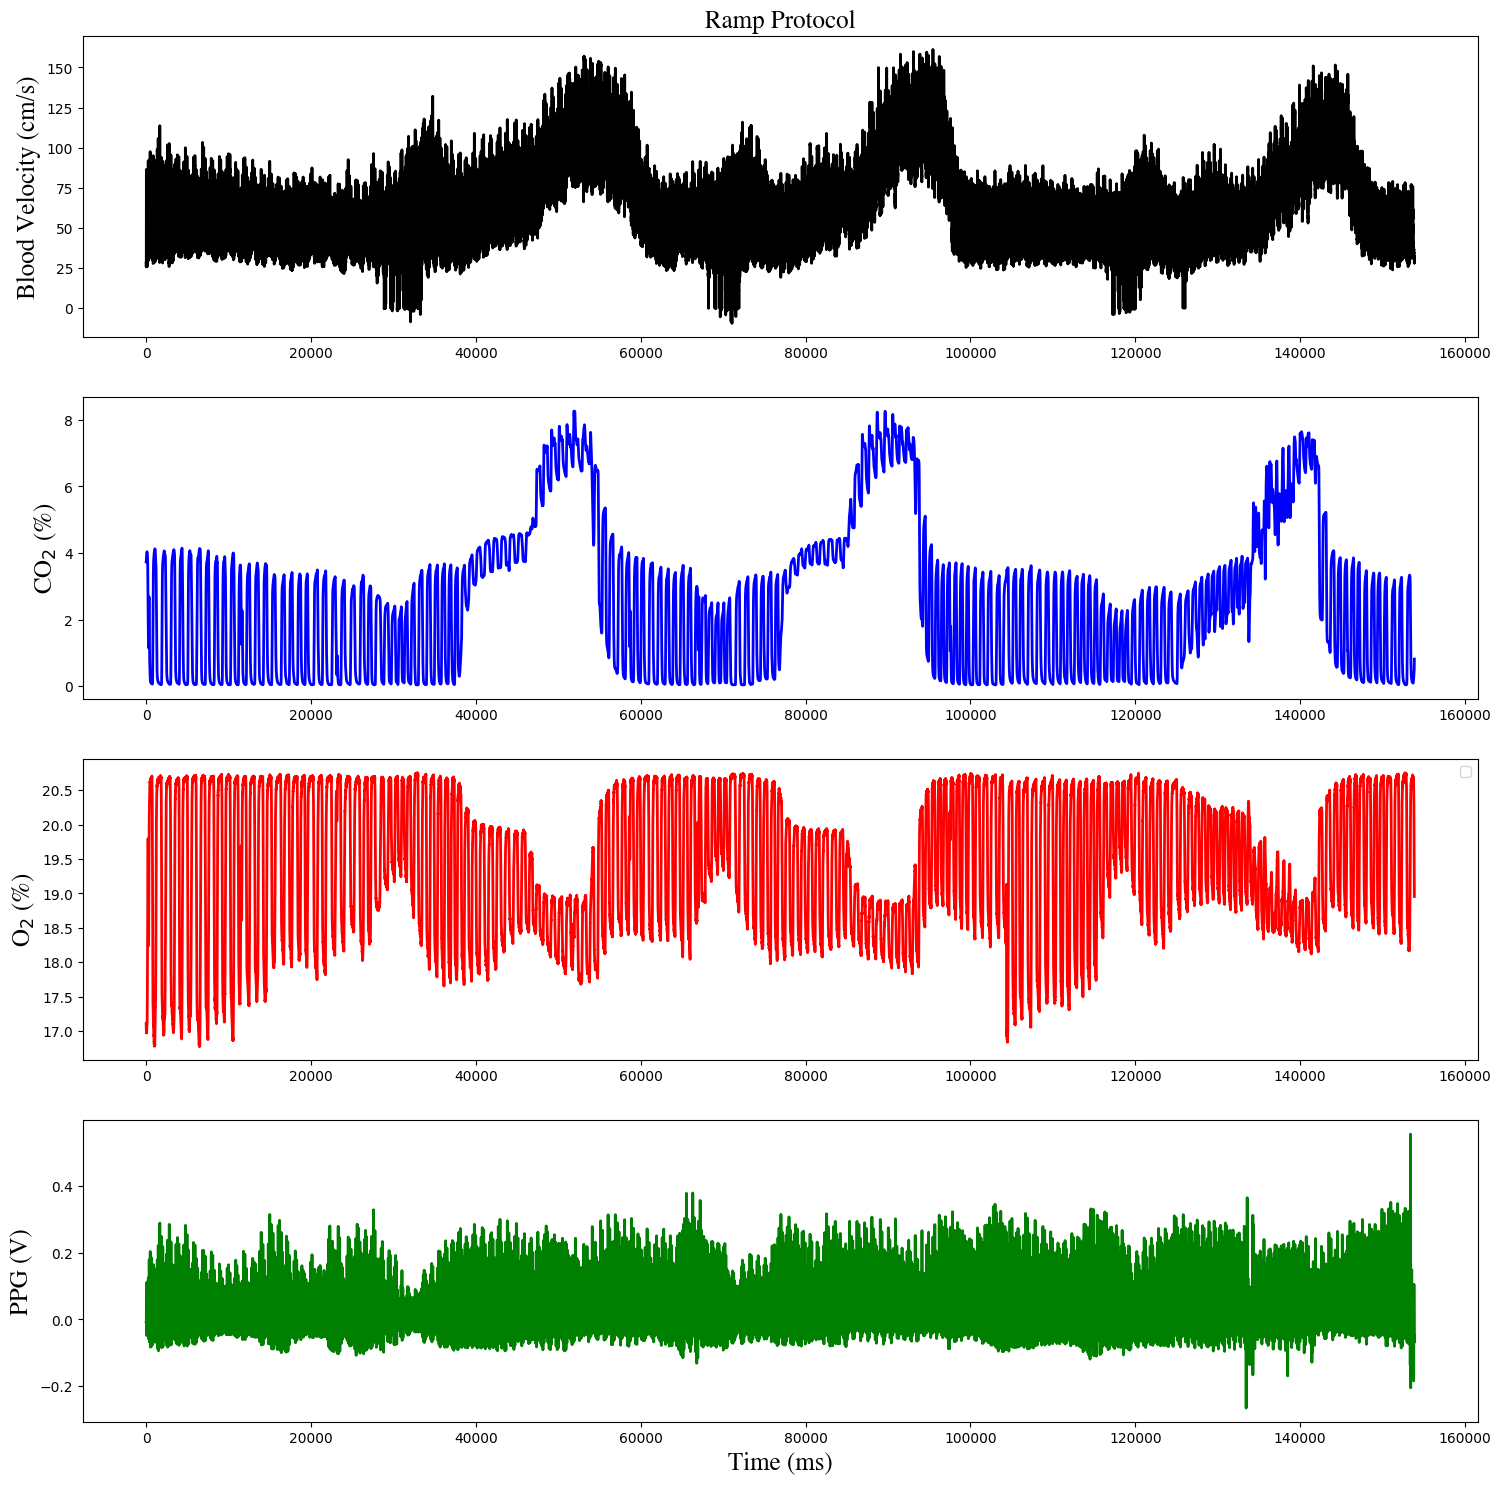

In [15]:
#plot
fig = plt.figure()

#plot parameters
fig.set_figheight(18)
fig.set_figwidth(18)
tfont = {'fontname':'Times'}

#plot TCD MCAv
ax1 = fig.add_subplot(411)
ax1.set_title("Ramp Protocol", fontsize=18, **tfont)       
ax1.set_ylabel('Blood Velocity (cm/s)', fontsize=18, **tfont)
TCD.plot(c="black", lw=2)

#plot CO2 percentage
ax2 = fig.add_subplot(412)   
ax2.set_ylabel('CO$_{2}$ (%)', fontsize=18, **tfont)
CO2.plot(c="blue", lw=2)

#plot O2 percentage
ax3 = fig.add_subplot(413)     
ax3.set_ylabel('O$_{2}$ (%)', fontsize=18, **tfont)
O2.plot(c="red", lw=2)
ax3.legend('')

#plot PPG readout(V)
ax4 = fig.add_subplot(414)   
ax4.set_xlabel('Time (ms)', fontsize=18, **tfont)    
ax4.set_ylabel('PPG (V)', fontsize=18, **tfont)
PPG.plot(c="green", lw=2)

# #remove the x-axis ticks and numbers
# ax1.set_xticklabels([])
# ax2.set_xticklabels([])
# ax3.set_xticklabels([])
# ax4.set_xticklabels([])


In [16]:
# Define search window as 0.5 seconds longer than the average breathing rate
br_avg, _, _, _ = cvr_func.get_average_breathing_rate(O2, sample_rate)
print('Average breathing rate:', 1/br_avg, 'seconds per breath')
# Define search window as 60% of the average breathing rate
search_window = (1/br_avg)*0.3
print('Sample rate:', sample_rate, 'Hz')
print('Search window:', search_window, 'seconds')

Average breathing rate: 4.995129870125327 seconds per breath
Sample rate: 200.0000000001819 Hz
Search window: 1.498538961037598 seconds


In [17]:
#### END TIDAL CO2 PEAKS FROM O2 VALLEYS ####

# Get the O2 end tidal val
TCD_th = copy.deepcopy(TCD)
#TCD_th[TCD_th < TCD_threshold] = np.nan

# print the starting index of the O2 data
print('--- O2 INDEX ---')
print(O2.index[0])
print(O2)

O2valleys_inds, O2valleys_vals, O2valleys_df = cvr_func.get_endtidal_valleys(np.array(O2), O2.index[0], search_window=search_window, sample_rate=200, height=O2_height, prominence=O2prominence)

# Define the end tidal CO2 peaks as the CO2 peaks that occur at each of the O2 valley points
CO2peaks_inds = O2valleys_inds
CO2peaks_vals = CO2[CO2peaks_inds]
# Make a dataframe of the CO2 peaks
CO2peaks_df = pd.DataFrame(CO2peaks_vals, index=CO2peaks_inds)
CO2peaks_df.columns = ['CO2']

--- O2 INDEX ---
0
0         17.11250
1         17.10625
2         17.09375
3         17.08750
4         17.08125
            ...   
153845    19.04062
153846    19.01875
153847    19.00000
153848    18.98125
153849    18.95625
Name: Channel 2 - O2, Length: 153850, dtype: float64


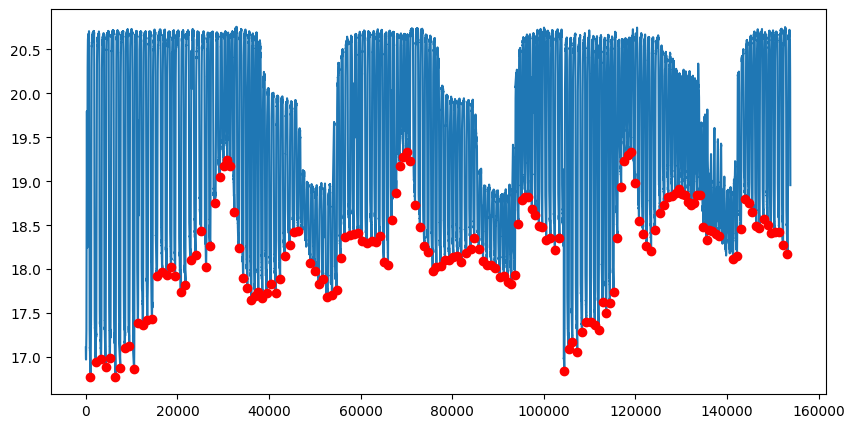

In [18]:
# plot the O2 valleys and CO2 peaks
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(O2)
ax.plot(O2valleys_inds, O2valleys_vals, 'ro')

shape of co2 peaks: (167, 1)


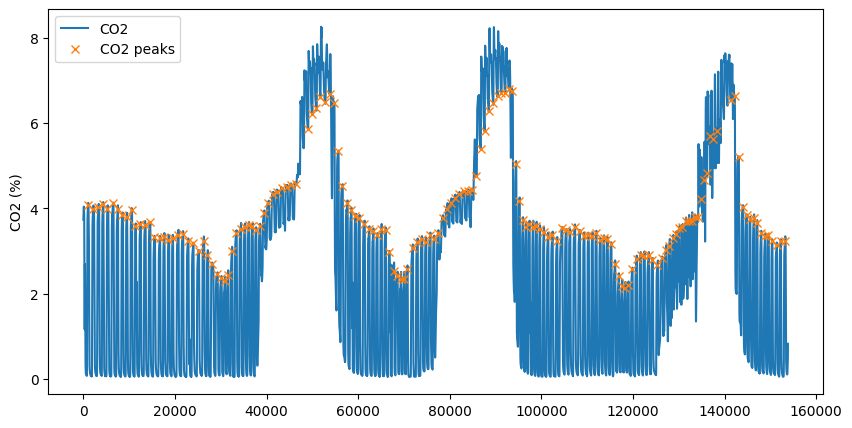

In [19]:
print('shape of co2 peaks:',CO2peaks_df.shape)

# plot the CO2 peaks
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(CO2, label='CO2')
ax.plot(CO2peaks_df, 'x', label='CO2 peaks')
ax.legend()
plt.ylabel('CO2 (%)')
plt.show()
 

In [ ]:
# remove large outliers from the PETCO2 data
# create a function to remove outliers relative to the 2 points before and after (excluding the first and last points)
def remove_outliers(data, threshold=20):
    #if the difference between the point and the 2 points before and after is greater than 20% then remove the point
    print('--- REMOVING OUTLIERS ---')
    for i in range(2,len(data)-2):
        if abs(data[i] - data[i-2]) > threshold and abs(data[i] - data[i+2]) > threshold:
            print('Removing outlier:', data[i])
            data[i] = np.nan     
    return data

Removing outlier: 2.990625
Removing outlier: 5.869688
Removing outlier: 5.340313
Removing outlier: 4.529062
Removing outlier: 2.978437
Removing outlier: 5.40375
Removing outlier: 5.816875
Removing outlier: 5.042188
Removing outlier: 4.182813
Removing outlier: 2.693438
Removing outlier: 4.216562
Removing outlier: 4.660313
Removing outlier: 4.841875
Removing outlier: 5.630625
Removing outlier: 6.535937
Removing outlier: 6.632812
Removing outlier: 5.201562
Number of NaN values in CO2 peaks cleaned: CO2    17
dtype: int64


/var/folders/ck/546jljvj7g3cptvhpxg8p2qh0000gn/T/ipykernel_62647/275312571.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  CO2peaks_df_cleaned.iloc[i]['CO2'] = np.nan


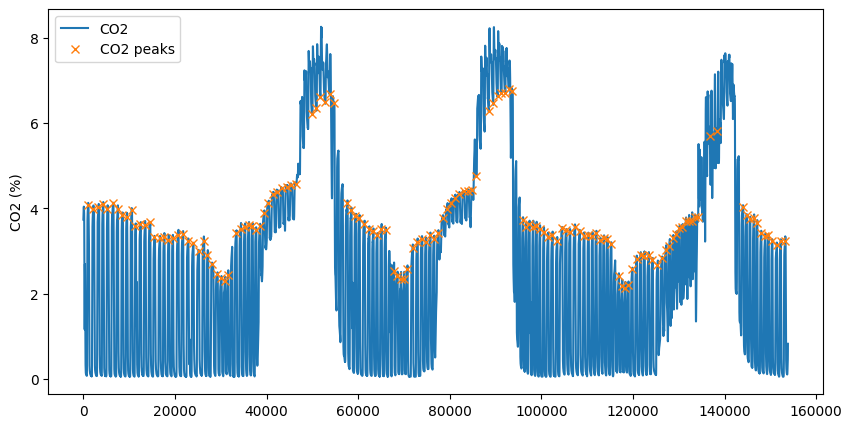

In [21]:
# initialize CO2peaks_df_cleaned 
CO2peaks_df_cleaned = copy.deepcopy(CO2peaks_df)

for i in range(3,len(CO2peaks_df)-3):
    #calculate the mean of the 2 points before and after the current point
    mean_before = np.mean([CO2peaks_df.iloc[i-3]["CO2"], CO2peaks_df.iloc[i-2]['CO2'], CO2peaks_df.iloc[i-1]['CO2']])
    mean_after = np.mean([CO2peaks_df.iloc[i+1]['CO2'], CO2peaks_df.iloc[i+2]['CO2'], CO2peaks_df.iloc[i+3]['CO2']])
    if abs(CO2peaks_df.iloc[i]['CO2'] - mean_before) > peak_dif_thresh and abs(CO2peaks_df.iloc[i]['CO2'] - mean_after) > peak_dif_thresh:
        print('Removing outlier:', CO2peaks_df.iloc[i]['CO2'])
        CO2peaks_df_cleaned.iloc[i]['CO2'] = np.nan

#print the number of NaN values in the cleaned data
print('Number of NaN values in CO2 peaks cleaned:', CO2peaks_df_cleaned.isnull().sum())

# remove the NaN values from the CO2 peaks
CO2peaks_df_cleaned = CO2peaks_df_cleaned.dropna()

# plot the CO2 peaks
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(CO2, label='CO2')
ax.plot(CO2peaks_df_cleaned, 'x', label='CO2 peaks')
ax.legend()
plt.ylabel('CO2 (%)')
plt.show()

In [22]:
#CO2peaks_df = CO2peaks_df_cleaned

In [23]:
#### TCD ROLLING MEAN ####

print(sample_rate, '1/s')
print('Averaging over', int(20*sample_rate), 'samples = 20 seconds')

# Take a rolling mean of the TCD data with a window of 5 seconds to get the average blood velocity and save it as TCD_rolling not including nan values
TCD_rolling = TCD_th.rolling(int(20*sample_rate)).mean()

# interpolate the nan values in the TCD rolling
TCD_rolling = TCD_rolling.interpolate(method='slinear', limit_direction='both')
#TCD_rolling = TCD_th.rolling(int(20*sample_rate),min_periods=15).mean().fillna(method='bfill')

# print the number of nan values in the TCD rolling
print('Number of NaN values in TCD rolling:', TCD_rolling.isnull().sum())

200.0000000001819 1/s
Averaging over 4000 samples = 20 seconds
Number of NaN values in TCD rolling: 3999


153850
153850
118850
118850


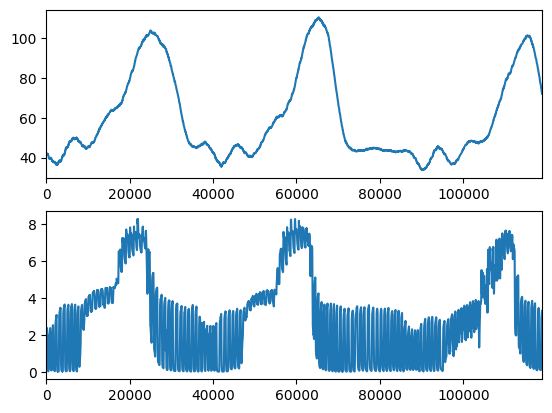

In [24]:
print(len(TCD_rolling))
print(len(CO2))

front_crop = 30000
back_crop = 5000 #5000

A= np.array(TCD_rolling)
B= np.array(CO2)

a=np.ma.masked_invalid(A)
b=np.ma.masked_invalid(B)

msk = (~a.mask & ~b.mask)

# remove first 5 seconds and last 5 seconds of tcd data
func = a[front_crop:-back_crop]
co2 = b[front_crop:-back_crop]

print(len(func))
print(len(co2))

# plot the func on the top plot and the co2 on the bottom plot
plt.figure()
plt.subplot(211)
plt.plot(func)
plt.xlim(0, len(co2))
plt.subplot(212)
plt.plot(co2)
# use same x axis for both plots
plt.xlim(0, len(co2))
plt.show()


Number of NaN values in CO2: 0
length of func_fft_peaks: 38949
mean of func_fft_peaks: 59425.0
length of co2_fft_peaks: 44143
mean of co2_fft_peaks: 59425.0
length of func_fft after cropping: 118850


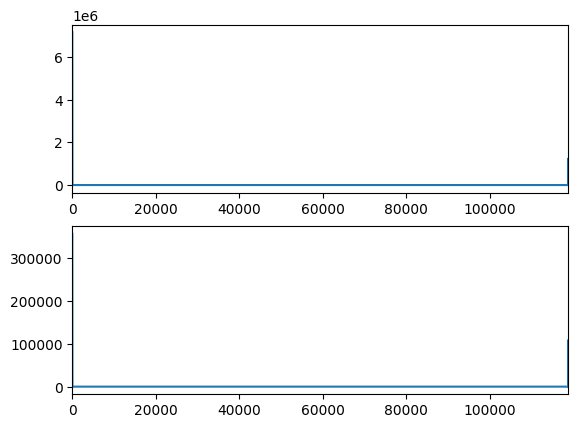

/Users/ghayes/miniconda3/envs/sigcvr/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ghayes/miniconda3/envs/sigcvr/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


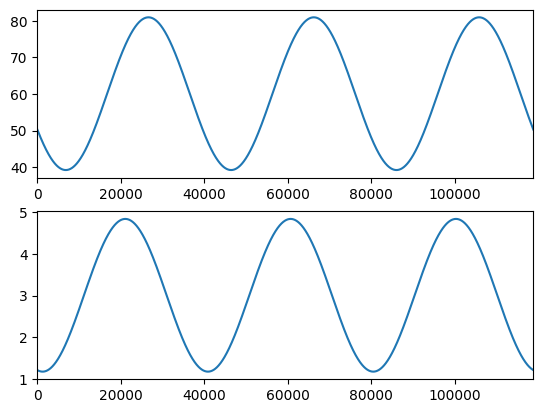

In [ ]:
# remove nan values from co2 data
print('Number of NaN values in CO2:', np.isnan(co2).sum())
co2 = co2[~np.isnan(co2)]

# do a fourier transfrom of func and co2 data and only keep frequencies that are the most prominant
func_fft = fft(func)
co2_fft = fft(co2)

# Keep only the largest frequency peak
# find the peaks in the fft of the func and co2 data
func_fft_peaks, _ = find_peaks(np.abs(func_fft))
co2_fft_peaks, _ = find_peaks(np.abs(co2_fft))
print('length of func_fft_peaks:', len(func_fft_peaks))
print('mean of func_fft_peaks:', np.mean(func_fft_peaks))
print('length of co2_fft_peaks:', len(co2_fft_peaks))
print('mean of co2_fft_peaks:', np.mean(co2_fft_peaks))
# set all frequencies to zero except the largest frequency peak
func_fft[np.abs(func_fft) < np.max(np.abs(func_fft[func_fft_peaks]))] = 0
co2_fft[np.abs(co2_fft) < np.max(np.abs(co2_fft[co2_fft_peaks]))] = 0

print('length of func_fft after cropping:', len(func_fft))

# inverse fourier transform
func_smooth = ifft(func_fft)
co2_smooth = ifft(co2_fft)
# plot the fft of the func and co2 data
plt.figure()
plt.subplot(211)
plt.plot(np.abs(func_fft))
plt.xlim(0, len(co2))
plt.subplot(212)
plt.plot(np.abs(co2_fft))
# align the x axis of the two plots
plt.xlim(0, len(co2))

plt.show()

# plot the func on the top plot and the co2 on the bottom plot
plt.figure()
plt.subplot(211)
plt.plot(func_smooth)
plt.xlim(0, len(co2))
plt.subplot(212)
plt.plot(co2_smooth)
plt.xlim(0, len(co2))
plt.show()

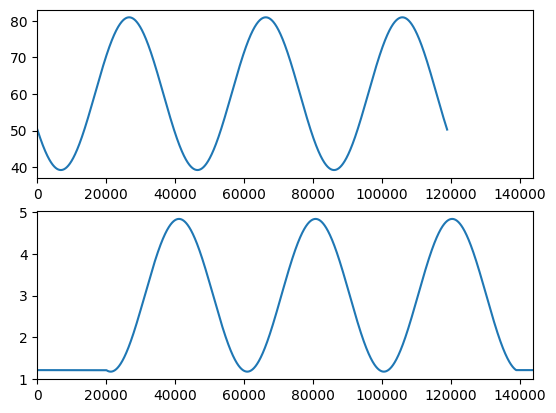

In [26]:
# pad the beginning of co2 with zeros 'front_crop' times and the back with zeros 'back_crop' times
co2_smooth_padded = np.pad(co2_smooth, (20000, back_crop), 'constant', constant_values=(co2_smooth[1], co2_smooth[-1]))

# plot the func on the top plot and the co2 on the bottom plot
plt.figure()
plt.subplot(211)
plt.plot(func_smooth)
plt.xlim(0, len(co2_smooth_padded))
plt.subplot(212)
plt.plot(co2_smooth_padded)
plt.xlim(0, len(co2_smooth_padded))
plt.show()

In [27]:
func = func_smooth.copy()
co2 = co2_smooth_padded.copy()

/Users/ghayes/miniconda3/envs/sigcvr/lib/python3.9/site-packages/scipy/signal/_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


func_smooth_largest_peaks: [80.98563919+1.78237238e-14j 80.9856392 +7.75517351e-16j
 80.98563922-2.01765455e-15j]
co2_smooth_largest_peaks: [4.84412639-1.59230020e-15j 4.8441264 -1.24241902e-16j
 4.8441264 -8.77879276e-16j]
func_smooth_largest_peaks_inds: [2 0 1]
co2_smooth_largest_peaks_inds: [2 3 1]
123041
time_shift: -4191


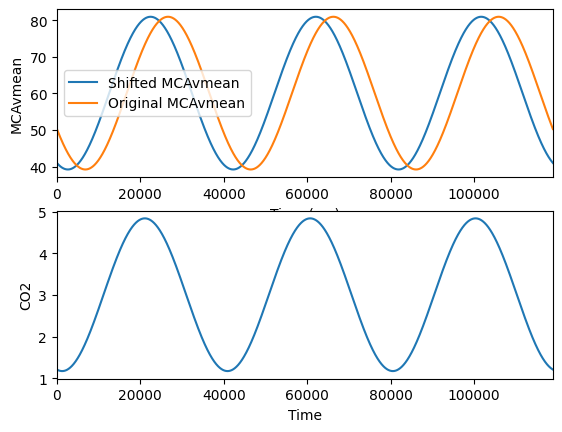

In [28]:
# align the 3 largest peaks in the func_smooth and co2_smooth_padded data
# find the peaks in the func and co2 data
func_smooth_peaks, _ = find_peaks(func_smooth, height=0)
co2_smooth_peaks, _ = find_peaks(co2_smooth_padded, height=0)
# find the 3 largest peaks in the func and co2 data
func_smooth_largest_peaks = np.sort(func_smooth[func_smooth_peaks])[-3:]
co2_smooth_largest_peaks = np.sort(co2_smooth_padded[co2_smooth_peaks])[-3:]
# find the indices of the 3 largest peaks in the func and co2 data
func_smooth_largest_peaks_inds = np.argsort(func_smooth[func_smooth_peaks])[-3:]
co2_smooth_largest_peaks_inds = np.argsort(co2_smooth_padded[co2_smooth_peaks])[-3:]
# print the 3 largest peaks in the func and co2 data
print('func_smooth_largest_peaks:', func_smooth_largest_peaks)
print('co2_smooth_largest_peaks:', co2_smooth_largest_peaks)
# print the indices of the 3 largest peaks in the func and co2 data
print('func_smooth_largest_peaks_inds:', func_smooth_largest_peaks_inds)
print('co2_smooth_largest_peaks_inds:', co2_smooth_largest_peaks_inds)

# align the 3 largest peaks in the func_smooth and co2_smooth_padded data
# find the time shift between func and co2
C = np.correlate(func_smooth,co2_smooth, "full")
# find the index of the maximum value in the correlation
max_corr_ind = np.argmax(C)
print(max_corr_ind)
# find the time shift between the two signals
time_shift = len(co2_smooth) - max_corr_ind
print('time_shift:', time_shift)

# shift the func data by the time shift
func_SHIFT = np.roll(func_smooth, time_shift)
# plot the func on the top plot and the co2 on the bottom plot
plt.figure()
plt.subplot(211)
plt.plot(func_SHIFT, label='Shifted MCAvmean')
plt.plot(func_smooth, label='Original MCAvmean')
plt.xlabel('Time (ms)')
plt.ylabel('MCAvmean')
plt.legend()
plt.xlim(0, len(co2_smooth))

plt.subplot(212)
plt.plot(co2_smooth)
plt.xlim(0, len(co2_smooth))
plt.xlabel('Time')
plt.ylabel('CO2')
plt.show()


In [30]:
xcorr_shift = time_shift
corr = C

corr [ 60.66692044-3.53609175e-14j 121.33323687-1.25984724e-13j
 181.99895168-2.17903999e-13j ... 182.0044095 +1.93386780e-13j
 121.33566256+1.00260643e-13j  60.66752687+9.79823879e-14j]


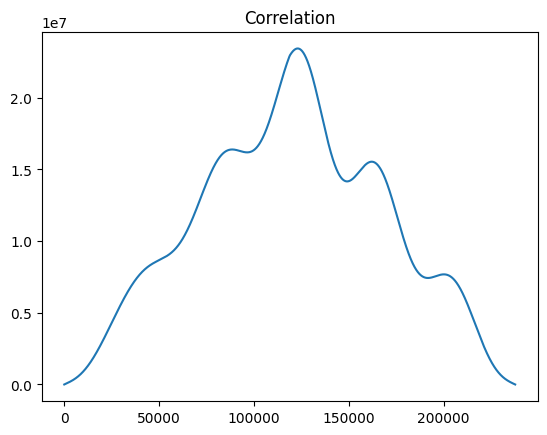

In [32]:
# plot correlation
fig = plt.figure()
plt.plot(corr)
plt.title('Correlation')
print('corr', corr)

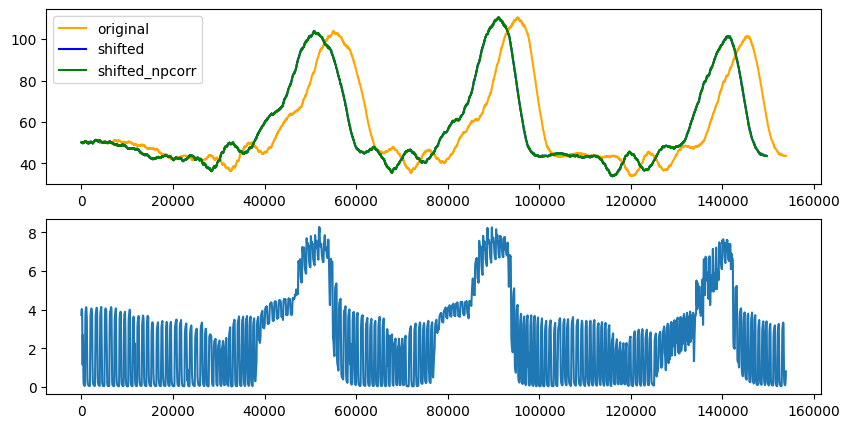

In [33]:
# shift TCD_rolling by the time shift
TCD_rolling_shifted = TCD_rolling.shift(periods=xcorr_shift, fill_value=np.nan)
TCD_rolling_shifted_2 = TCD_rolling.shift(periods=time_shift, fill_value=np.nan)

# plot TCD and CO2 with time shift
fig = plt.figure()
#plot parameters
fig.set_figheight(5)
fig.set_figwidth(10)
tfont = {'fontname':'Times'}
plt.subplot(211)
plt.plot(TCD_rolling, label='original', color='orange')
plt.plot(TCD_rolling_shifted, label='shifted', color='blue')
plt.plot(TCD_rolling_shifted_2, label='shifted_npcorr', color='green')
plt.legend()
#plt.xlim(0, len(TCD_rolling_shifted))
plt.subplot(212)
plt.plot(b)
# use same x axis for both plots
#plt.xlim(0, len(TCD_rolling_shifted))


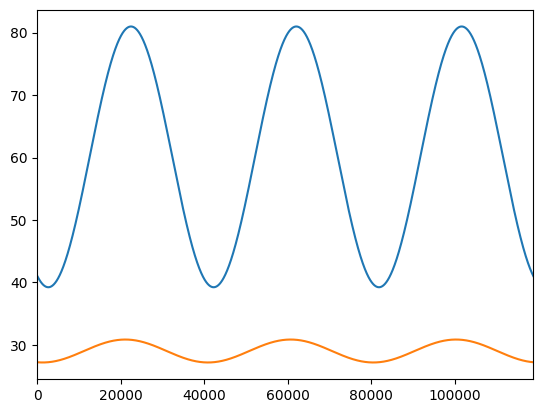

In [34]:
# plot the co2_smooth_padded on the same plot as the func_smooth shifted by the xcorr_shift time shift
plt.figure()
#shift func_smooth numpy array by xcorr_shift and padd the beginning with nans
func_smooth_shifted = np.roll(func, xcorr_shift)
plt.plot(func_smooth_shifted)
plt.plot(co2_smooth+26)

plt.xlim(0, len(co2_smooth))
plt.show()

In [35]:
# save a copy of the figure in as a png in the same sample_data folder
print('Saving xcorr figure...')
fig.savefig(local + 'sample_data/' + sub + '/' + ses + '/' + sub + '_' + ses + '_' + date + '_' + task + '_xcorr.png')

print('location of figure:', local + 'sample_data/' + sub + '/' + ses + '/' + sub + '_' + ses + '_' + date + '_' + task + '_xcorr.png')

Saving xcorr figure...
location of figure: /Users/ghayes/Desktop/Ramp_PWL/sample_data/sub-002/ses-01/sub-002_ses-01_20230816_task_dat-20230816_xcorr.png


In [ ]:
#### CO2 INTERPOLATION ####

# linearly interpolate the peak CO2 values to get the CO2 value at each TCD measurement
CO2peaks_interp = np.interp(TCD_rolling_shifted.index, CO2peaks_df.index, CO2peaks_df['CO2'])

# # interpolate using a cubic spline
# f = sp.interpolate.CubicSpline(CO2peaks_df.index, CO2peaks_df['CO2'], axis = 1 , bc_type='not-a-knot', extrapolate=None)
# CO2peaks_interp = f(TCD_rolling_shifted.index)

In [ ]:
#### SCALE CO2 DATA AND O2 DATA FROM PERCENT TO MMHG ####
print('Conversion factor from % to mmHg:', P_conversion_perc2mmHg)

# Scale the CO2 data from % to mmHg
CO2 = CO2*P_conversion_perc2mmHg
CO2peaks_df = CO2peaks_df*P_conversion_perc2mmHg
CO2peaks_interp = CO2peaks_interp*P_conversion_perc2mmHg

Conversion factor from % to mmHg: 7.633376657381283


In [39]:
TCD_th_shifted = TCD_th.shift(periods=xcorr_shift, fill_value=np.nan)

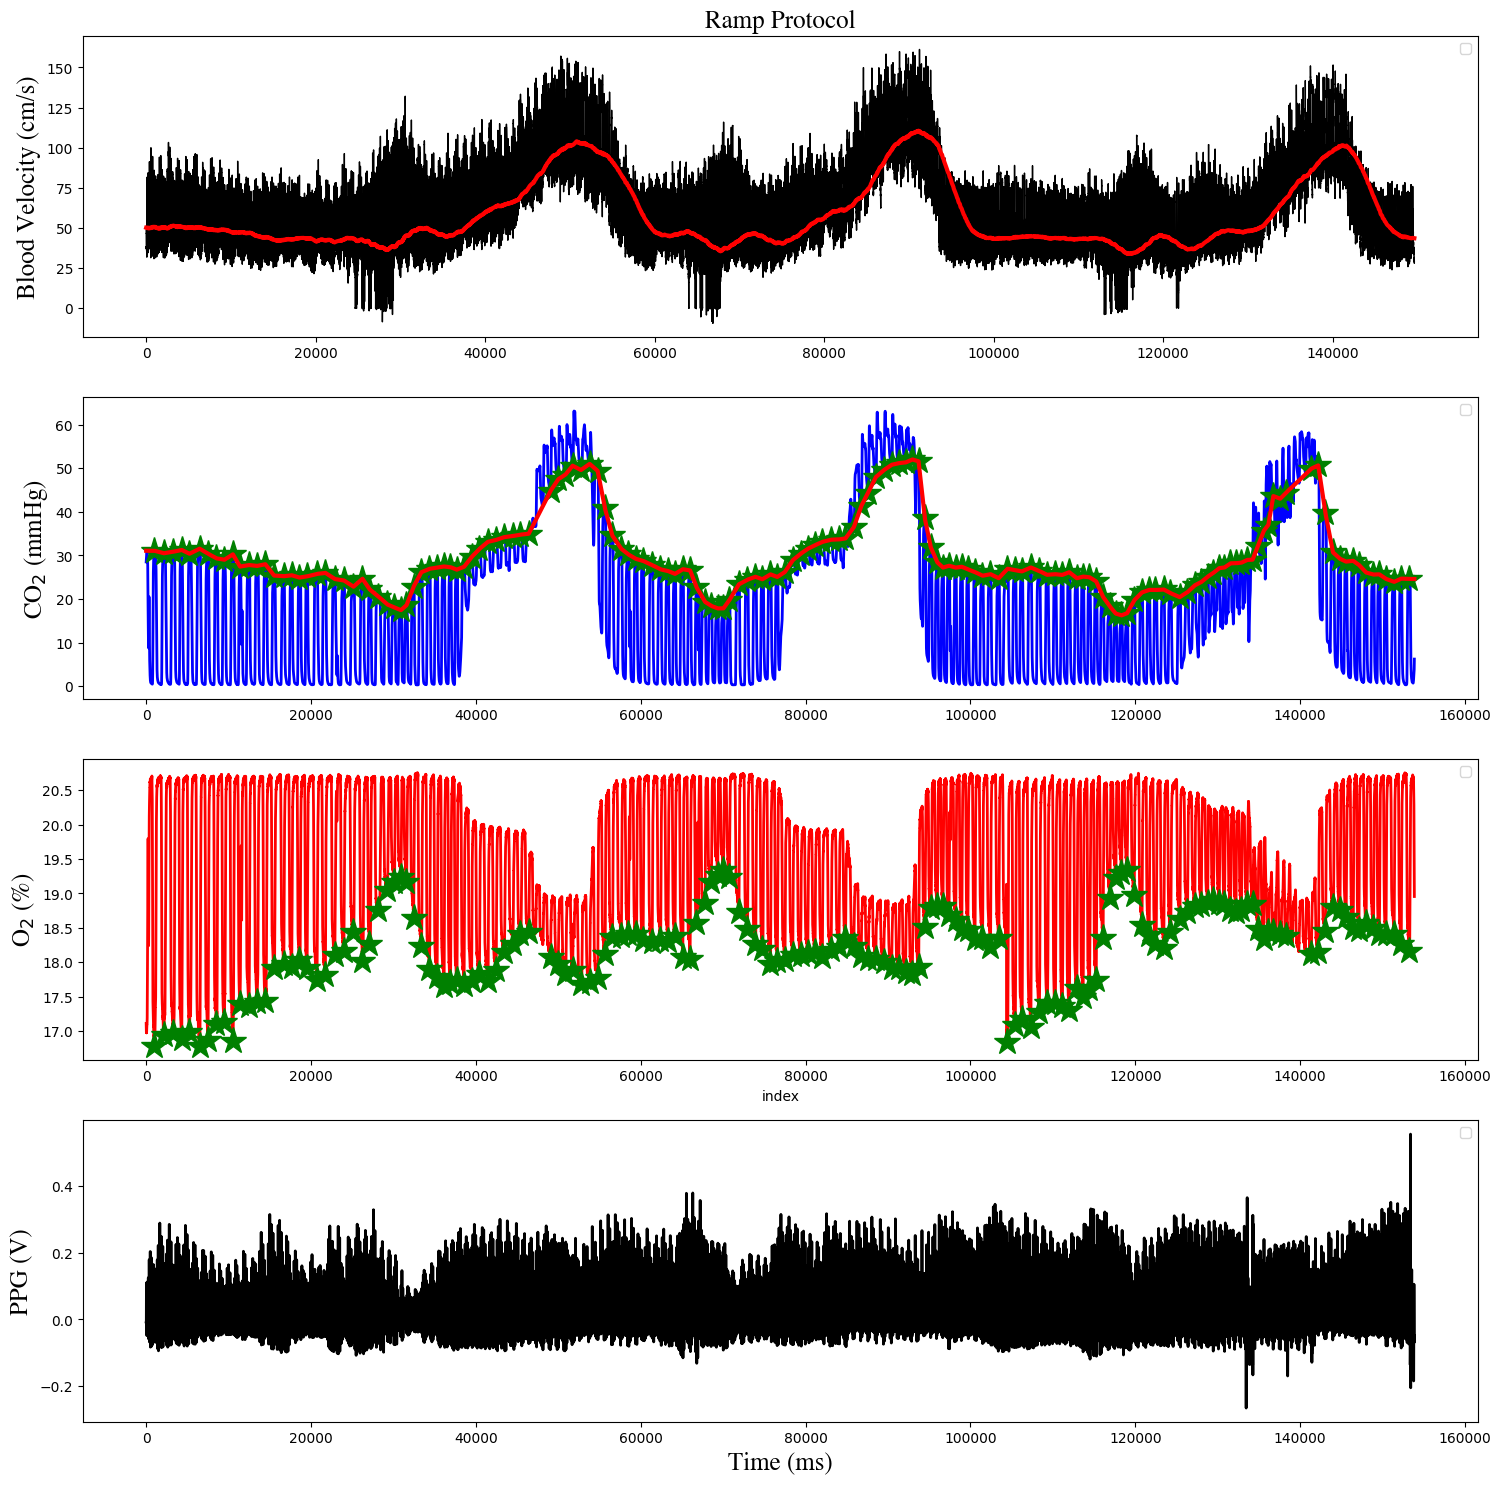

In [40]:
#plot
fig = plt.figure()

#plot parameters
fig.set_figheight(18)
fig.set_figwidth(18)
tfont = {'fontname':'Times'}

#plot TCD MCAv
ax1 = fig.add_subplot(411)
ax1.set_title("Ramp Protocol", fontsize=18, **tfont)       
ax1.set_ylabel('Blood Velocity (cm/s)', fontsize=18, **tfont)
TCD_th_shifted.plot(c="black", lw=1)
ax1.legend(['MCAvmax', 'MCAvmin', 'MCAvmean'], fontsize=10)
# overlay rolling mean on TCD plot
TCD_rolling_shifted.plot(c="red", lw=3)

#plot CO2 percentage
ax2 = fig.add_subplot(412)   
ax2.set_ylabel('CO$_{2}$ (mmHg)', fontsize=18, **tfont)
CO2.plot(c="blue", lw=2)
# plot the CO2 peaks
CO2peaks_df.plot(ax=ax2, marker='*',linestyle='None',markersize = 20.0, color = 'g')
ax2.legend(['End-Tidal CO2'], fontsize=10)
# overlay interpolated CO2 on CO2 plot
ax2.plot(TCD_rolling.index, CO2peaks_interp, c="red", lw=3)


#plot O2 percentage
ax3 = fig.add_subplot(413)     
ax3.set_ylabel('O$_{2}$ (%)', fontsize=18, **tfont)
O2.plot(c="red", lw=2)
O2valleys_df.plot(ax=ax3,x='index', y = 'val', marker='*',linestyle='None',markersize = 20.0, color = 'g')
ax3.legend(['End-Tidal O2'], fontsize=10)


#plot PPG readout(V)
ax4 = fig.add_subplot(414)   
ax4.set_xlabel('Time (ms)', fontsize=18, **tfont)    
ax4.set_ylabel('PPG (V)', fontsize=18, **tfont)
PPG.plot(c="black", lw=2)

# remove legend from all plots
ax1.legend('')
ax2.legend('')
ax3.legend('')
ax4.legend('')

plt.show()

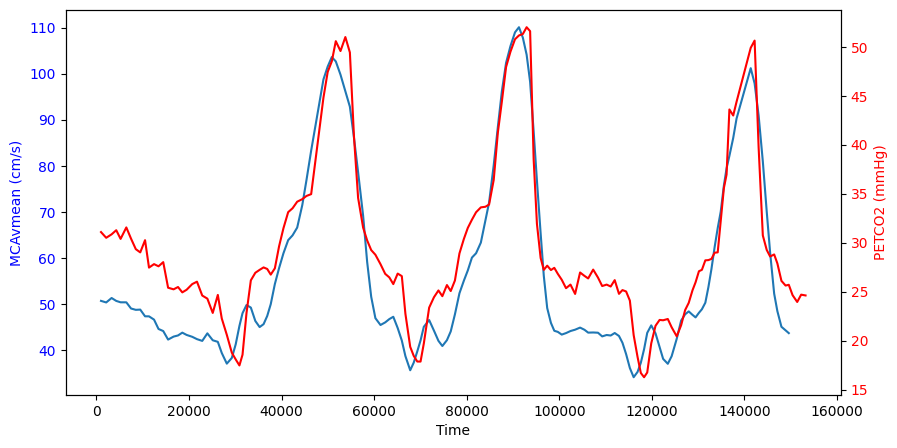

In [ ]:
# Plot the first column of mca relative to its index
# Define figure 
fig = plt.figure(figsize=(10,5))
plt.plot(TCD_rolling_shifted.loc[CO2peaks_df.index])
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(CO2peaks_df,'r')
ax2.set_ylabel('PETCO2 (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')

153850
167
167
153850


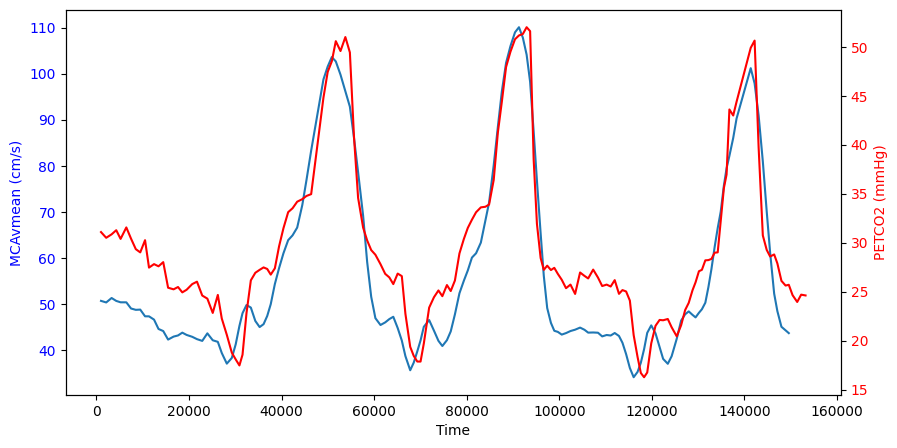

In [42]:
# manually shift the TCD_rolling_shifted data to align with the CO2 peaks
TCD_rolling_shifted_manual = TCD_rolling_shifted.shift(periods=man_shift, fill_value=np.nan)
# crop the end of CO2peaks_df to match the length of TCD_rolling_shifted_manual
CO2peaks_df_manual = CO2peaks_df.iloc[:len(TCD_rolling_shifted_manual)]

# Define figure 
fig5 = plt.figure(figsize=(10,5))
plt.plot(TCD_rolling_shifted_manual.loc[CO2peaks_df_manual.index])
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(CO2peaks_df_manual,'r')
ax2.set_ylabel('PETCO2 (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')

print(len(TCD_rolling_shifted_manual))
print(len(TCD_rolling_shifted_manual.loc[CO2peaks_df_manual.index]))
print(len(CO2peaks_df_manual))
print(len(CO2peaks_interp))

In [43]:
# save a copy of the figure in as a png in the same sample_data folder
fig5.savefig(local + 'sample_data/' + sub + '/' + ses + '/' + sub + '_' + ses + '_' + date + '_' + task + '_MCAvsPETCO2peaks_shifted.png')

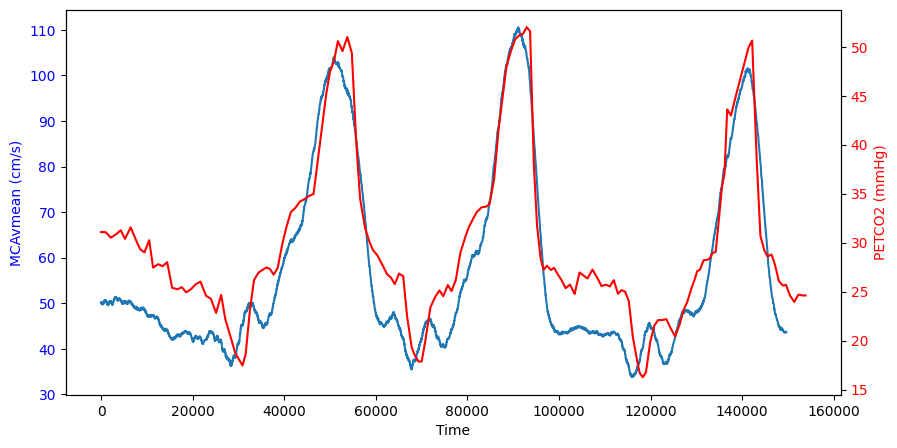

In [45]:
#reset the index of the tcd data
TCD_rolling_shifted_manual = TCD_rolling_shifted_manual.reset_index(drop=True)

# Define figure 
fig_interp_shift = plt.figure(figsize=(10,5))
plt.plot(TCD_rolling_shifted_manual)
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(CO2peaks_interp,'r')
ax2.set_ylabel('PETCO2 (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')

In [47]:
print('shape of co2 interp', CO2peaks_interp.shape)

shape of co2 interp (153850,)


In [48]:
#petco2_final = CO2peaks_df_manual_resampled
petco2_final = CO2peaks_interp
tcd_rolling_final = TCD_rolling_shifted_manual
TCD_th_manshifted = TCD_th.shift(periods=(man_shift), fill_value=np.nan)

In [49]:
# print size and datatype of TCD_rolling
print('Size of TCD_rolling:', len(tcd_rolling_final))
print('Datatype of TCD_rolling:', type(tcd_rolling_final))
# print size and datatype of CO2peaks_interp
print('Size of CO2peaks_interp:', len(petco2_final))
print('Datatype of CO2peaks_interp:', type(petco2_final))


Size of TCD_rolling: 153850
Datatype of TCD_rolling: <class 'pandas.core.series.Series'>
Size of CO2peaks_interp: 153850
Datatype of CO2peaks_interp: <class 'numpy.ndarray'>


In [50]:
# label the first header of TCD_rolling "time (ms)" and the second header "MCAvmean (cm/s)"
tcd_rolling_header = ['MCAvmean (cm/s)']
# label the first header of CO2peaks_interp "time (ms)" and the second header "PETCO2 (mmHg)"
petco2_header = ['PETCO2 (mmHg)']

# give TCD_rolling and CO2peaks_interp headers
tcd_rolling_final = pd.DataFrame(tcd_rolling_final)
tcd_rolling_final.columns = tcd_rolling_header
petco2_final = pd.DataFrame(petco2_final)
petco2_final.columns = petco2_header

print('SHAPE OF TCD ROLLING FINAL:', tcd_rolling_final.shape)
print('SHAPE OF PETCO2 FINAL:', petco2_final.shape)

#print the number of NaN values in the TCD_rolling_final data and the CO2peaks_interp data
print('Number of NaN values in TCD_rolling_final:', tcd_rolling_final.isnull().sum())
print('Number of NaN values in PETCO2_final:', petco2_final.isnull().sum())

SHAPE OF TCD ROLLING FINAL: (153850, 1)
SHAPE OF PETCO2 FINAL: (153850, 1)
Number of NaN values in TCD_rolling_final: MCAvmean (cm/s)    4191
dtype: int64
Number of NaN values in PETCO2_final: PETCO2 (mmHg)    0
dtype: int64


In [51]:
# save TCD_rolling and CO2peaks_interp as csv files of the same format and make name files the same as the original file but with _TCD_rolling and _CO2peaks_interp and save files in the same directory as the original file but in a folder called sample data

# generate the new filenames
tcd_rolling_filename = sub + '_' + ses + '_' + date + '_' + task + '_MCAvmean.csv'
petco2_filename = sub + '_' + ses + '_' + date + '_' + task + '_petco2.csv'

# save the TCD_rolling and petco2 data as csv files
tcd_rolling_final.to_csv(local + 'sample_data/' + sub + '/' + ses + '/' + tcd_rolling_filename)
petco2_final.to_csv(local + 'sample_data/' + sub + '/' + ses + '/' + petco2_filename)

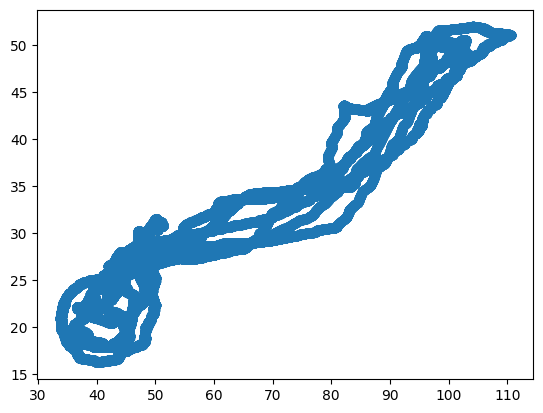

In [52]:
# plot the TCD_rolling as a function of CO2peaks_interp data
fig_comparison = plt.figure()
plt.plot(TCD_rolling_shifted, CO2peaks_interp, 'o')


Shape of TCD_rolling_CO2peaks: (167,)
Shape of CO2peaks_df: (167, 1)


Text(0, 0.5, 'TCD_rolling (cm/s)')

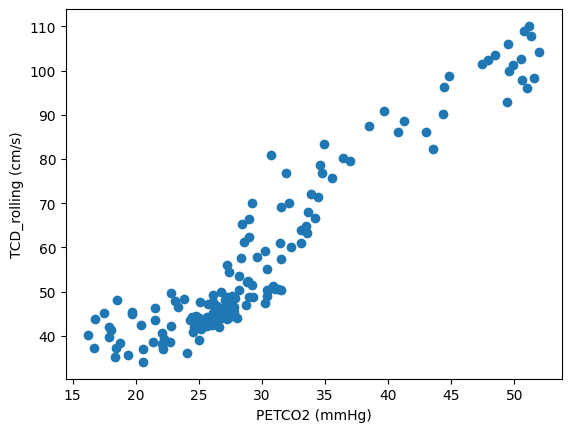

In [53]:
# get the tcd value from the TCD_rolling dataframe that is closest to each CO2 peak index
TCD_rolling_CO2peaks = TCD_rolling_shifted.loc[CO2peaks_df.index]
# print the shape of TCD_rolling_CO2peaks and CO2peaks_df
print('Shape of TCD_rolling_CO2peaks:', TCD_rolling_CO2peaks.shape)
print('Shape of CO2peaks_df:', CO2peaks_df.shape)

# plot the TCD_rolling_CO2peaks vs. CO2peaks_df
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(CO2peaks_df, TCD_rolling_CO2peaks, 'o')
ax.set_xlabel('PETCO2 (mmHg)')
ax.set_ylabel('TCD_rolling (cm/s)')



In [54]:
# save a copy of the figure in as a png in the same sample_data folder
fig.savefig(local + 'sample_data/' + sub + '/' + ses + '/' + sub + '_' + ses + '_' + date + '_' + task + '_scatter_comparison.png')

In [55]:
# save PEAK CO2 and corresponding TCD MCAvmean as csv files
# get the original file name and remove the extension
filename_split = filename.split('.')
# remove the first element if it is 'new'
if filename_split[0] == 'new':
    filename_split = filename_split[1:]

filename_split = filename_split[0]
# get sub and ses number
sub_ses = filename_split.split('_')

# remove the first element if it is 'new'
if sub_ses[0] == 'new':
    sub_ses = sub_ses[1:]

sub = sub_ses[0]
ses = sub_ses[1]

# get the date
date = filename_split.split('-')
date = date[3]
# get the task
task = filename_split.split('_')
task = task[3]

# generate the new filenames
TCD_atpeaks_filename = sub + '_' + ses + '_' + date + '_' + task + '_MCAvmean_atpeaks_shifted.csv'
CO2peaks_filename = sub + '_' + ses + '_' + date + '_' + task + '_petco2_peaks_shifted.csv'


# make a directory for the sample data if it doesn't already exist
if not os.path.exists(local + 'sample_data/' + sub + '/' + ses):
    os.makedirs(local + 'sample_data/' + sub + '/' + ses)

# # save the TCD_rolling and CO2peaks_interp as csv files
# TCD_rolling_CO2peaks.to_csv(local + 'sample_data/' + sub + '/' + ses + '/' + TCD_atpeaks_filename)
# CO2peaks_df.to_csv(local + 'sample_data/' + sub + '/' + ses + '/' + CO2peaks_filename)

In [56]:
############################################################################

In [57]:
peaks_inds, peaks_vals, peaks_df = cvr_func.get_tcd_peaks(TCD_th, TCD_th.index[0], search_window=6, sample_rate=200, height=0, prominence=2)
valleys_inds, valleys_vals, valleys_df = cvr_func.get_tcd_valleys(TCD_th, TCD_th.index[0], search_window=6, sample_rate=200, height=-50, prominence=1)

print('peaks', peaks_inds)
print('valleys', valleys_inds)
print('peaks', peaks_df)
print('valleys', valleys_df)

peaks [   359   1651   3002   4753   6824   8072   9984  11968  13278  14988
  17934  20116  22279  24509  25756  27578  29361  30596  31831  33514
  34760  37021  38268  39812  41763  43807  45901  48363  50068  51371
  53126  54899  56917  58876  60774  62118  63574  65532  67213  69358
  70562  72334  74112  75387  76997  78791  80543  82535  84219  85547
  86926  88837  91504  93093  95450  96763  98039  99266 100838 102970
 104796 106668 108788 110110 111465 113773 115528 116943 119289 121076
 122822 124110 125805 128145 129565 130924 132279 133647 134958 136369
 137695 139923 141586 142796 144258 145782 147544 149086 151224 152728]
valleys [    10   1212   2780   5111   6379   8563  10587  12310  14331  16345
  17692  19192  21552  22776  23993  26253  28022  29850  32067  33357
  35052  36466  38099  39374  40928  42903  44147  45880  47493  60207
  61892  63111  65515  66733  68221  69645  71068  72725  73962  75525
  76985  78323  80726  82029  83572  85319  86618  88020  9801

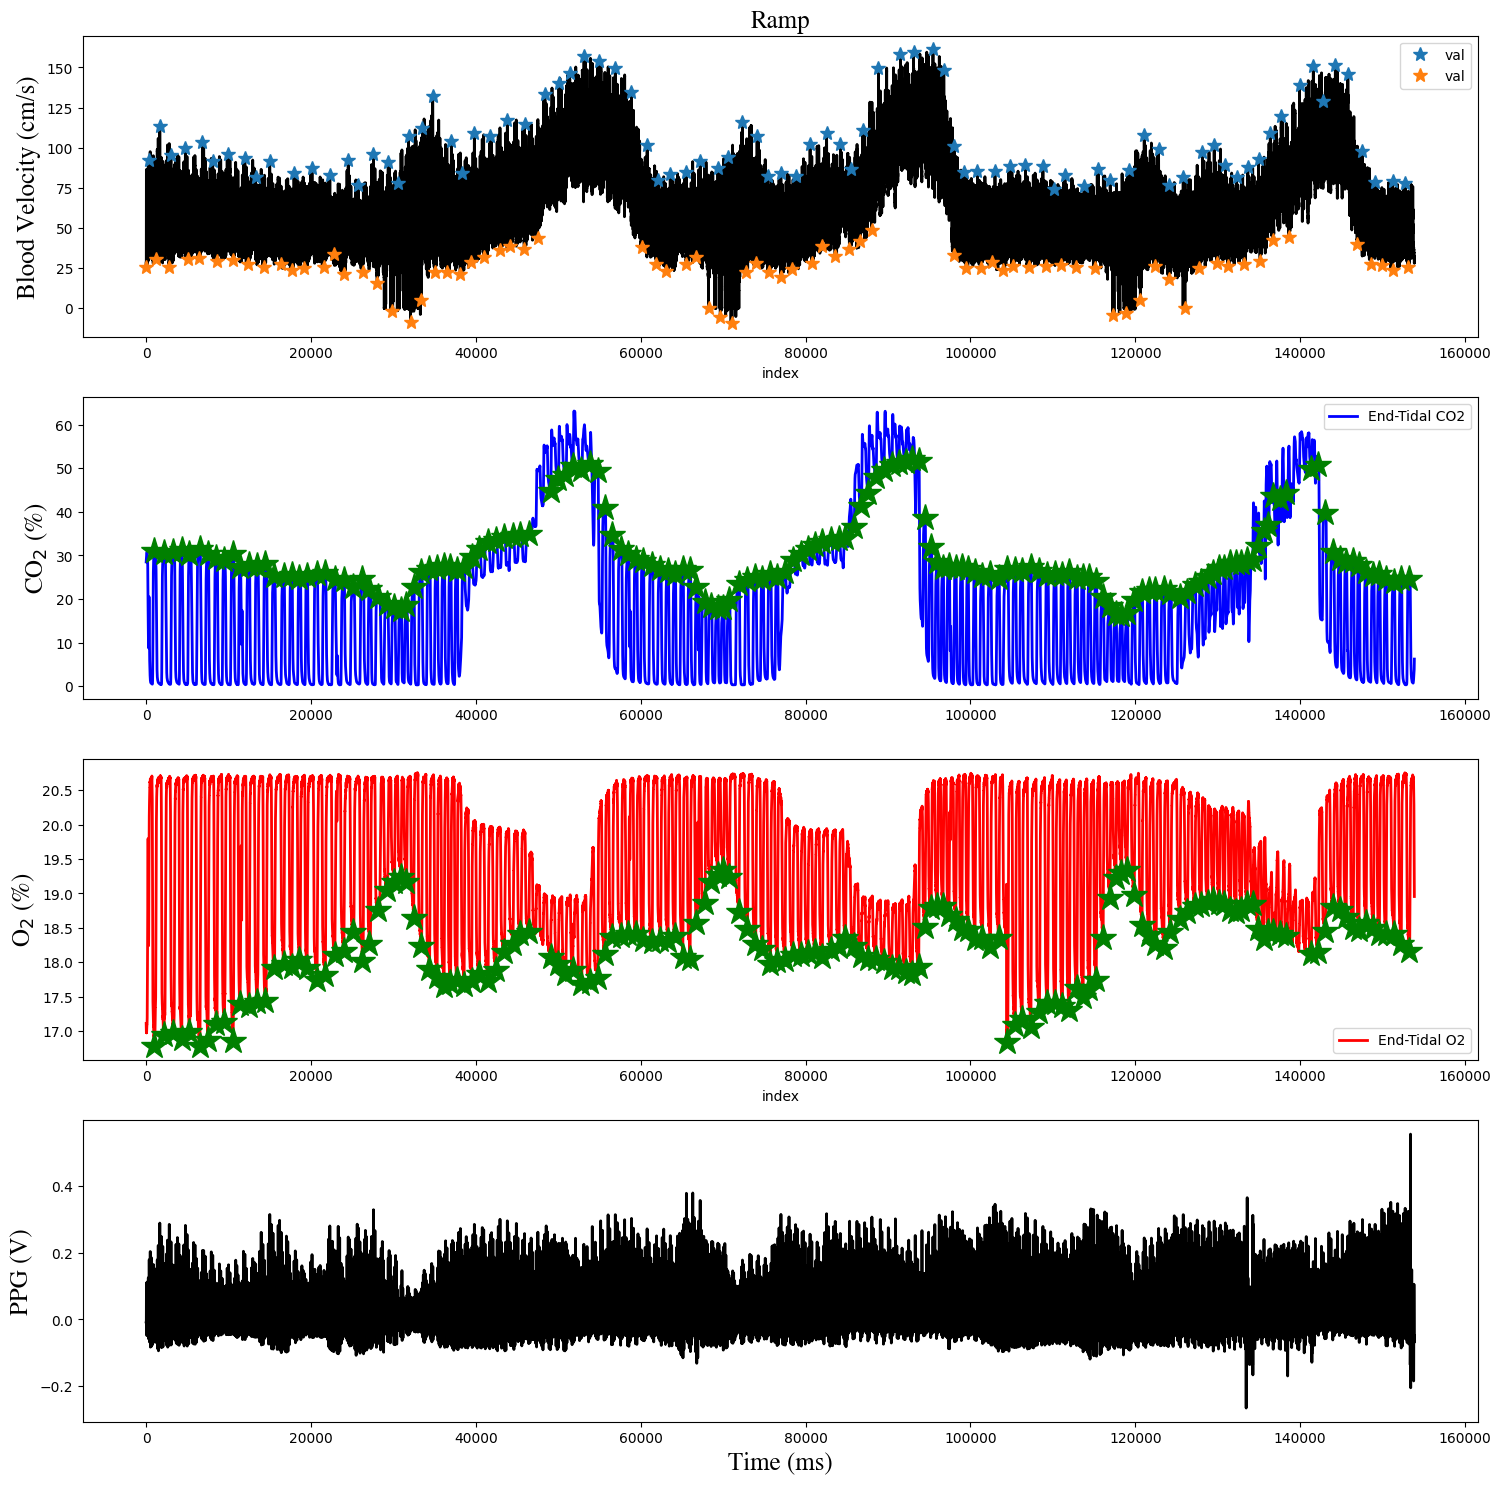

In [58]:
#plot
fig = plt.figure()

#plot parameters
fig.set_figheight(18)
fig.set_figwidth(18)
tfont = {'fontname':'Times'}

#plot TCD MCAv
ax1 = fig.add_subplot(411)
ax1.set_title("Ramp", fontsize=18, **tfont)       
ax1.set_ylabel('Blood Velocity (cm/s)', fontsize=18, **tfont)
TCD_th.plot(c="black", lw=2)
peaks_df.plot(ax=ax1, x='index', y='val',marker='*',linestyle='None',markersize = 10.0)
valleys_df.plot(ax=ax1, x='index', y='val',marker='*',linestyle='None',markersize = 10.0)


#plot CO2 percentage
ax2 = fig.add_subplot(412)   
ax2.set_ylabel('CO$_{2}$ (%)', fontsize=18, **tfont)
CO2.plot(c="blue", lw=2)
# plot the CO2 peaks
CO2peaks_df.plot(ax=ax2, marker='*',linestyle='None',markersize = 20.0, color = 'g')
ax2.legend(['End-Tidal CO2'], fontsize=10)


#plot O2 percentage
ax3 = fig.add_subplot(413)     
ax3.set_ylabel('O$_{2}$ (%)', fontsize=18, **tfont)
O2.plot(c="red", lw=2)
O2valleys_df.plot(ax=ax3,x='index', y = 'val', marker='*',linestyle='None',markersize = 20.0, color = 'g')
ax3.legend(['End-Tidal O2'], fontsize=10)


#plot PPG readout(V)
ax4 = fig.add_subplot(414)   
ax4.set_xlabel('Time (ms)', fontsize=18, **tfont)    
ax4.set_ylabel('PPG (V)', fontsize=18, **tfont)
PPG.plot(c="black", lw=2)

plt.show()


In [ ]:
# Get the average TCD velocity within the tcd_window_size
tcd_window_size = 0.5 # seconds
tcd_window_size *= sample_rate
tcd_window_size = int(tcd_window_size)
print('TCD window size:', tcd_window_size, 'samples')
print(TCD_th.loc[1:3])


# Get the average TCD velocity within the tcd_window_size for each of the end tidal CO2 peaks
CO2peaks_tcd = []
for i in range(len(CO2peaks_inds)-1):
    tcd_start_window = CO2peaks_inds[i]-tcd_window_size
    tcd_end_window = CO2peaks_inds[i]+tcd_window_size
    print(tcd_start_window)
    print(tcd_end_window)
    print(TCD_th[tcd_start_window:tcd_end_window])
    print('_____')
    CO2peaks_tcd.append(np.nanmean(TCD_th.loc[tcd_start_window:tcd_end_window]))
CO2peaks_tcd = np.array(CO2peaks_tcd)

print('CO2peaks_tcd', CO2peaks_tcd)

TCD window size: 100 samples
1    27.437307
2    27.532038
3    27.658331
Name: Channel 3 - TCD, dtype: float64
907
1107
907     34.572904
908     34.446610
909     34.636071
910     39.908825
911     39.561507
          ...    
1102    40.635004
1103    39.845678
1104    91.941850
1105    78.838863
1106    78.996741
Name: Channel 3 - TCD, Length: 200, dtype: float64
_____
2029
2229
2029    55.979695
2030    55.695544
2031    54.464170
2032    54.622047
2033    54.653610
          ...    
2224    51.590997
2225    51.748854
2226    52.285612
2227    52.159319
2228    52.380343
Name: Channel 3 - TCD, Length: 200, dtype: float64
_____
3196
3396
3196    74.071284
3197    62.989018
3198    63.115291
3199    63.304732
3200    58.410859
          ...    
3391    52.664494
3392    52.822351
3393    52.664494
3394    54.243166
3395    54.369459
Name: Channel 3 - TCD, Length: 200, dtype: float64
_____
4200
4400
4200    42.308406
4201    42.497847
4202    39.340503
4203    39.245793
4204    39.0

In [60]:
print('CO2 peak values : ', CO2peaks_vals.shape)
print('CO2peaks_tcd.shape : ', CO2peaks_tcd.shape)

vals_range_end = 24
tcd_range_end = 24

CO2 peak values :  (167,)
CO2peaks_tcd.shape :  (166,)


/var/folders/ck/546jljvj7g3cptvhpxg8p2qh0000gn/T/ipykernel_62647/1963820824.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(np.arange(0, len(CO2peaks_interp), step=100))


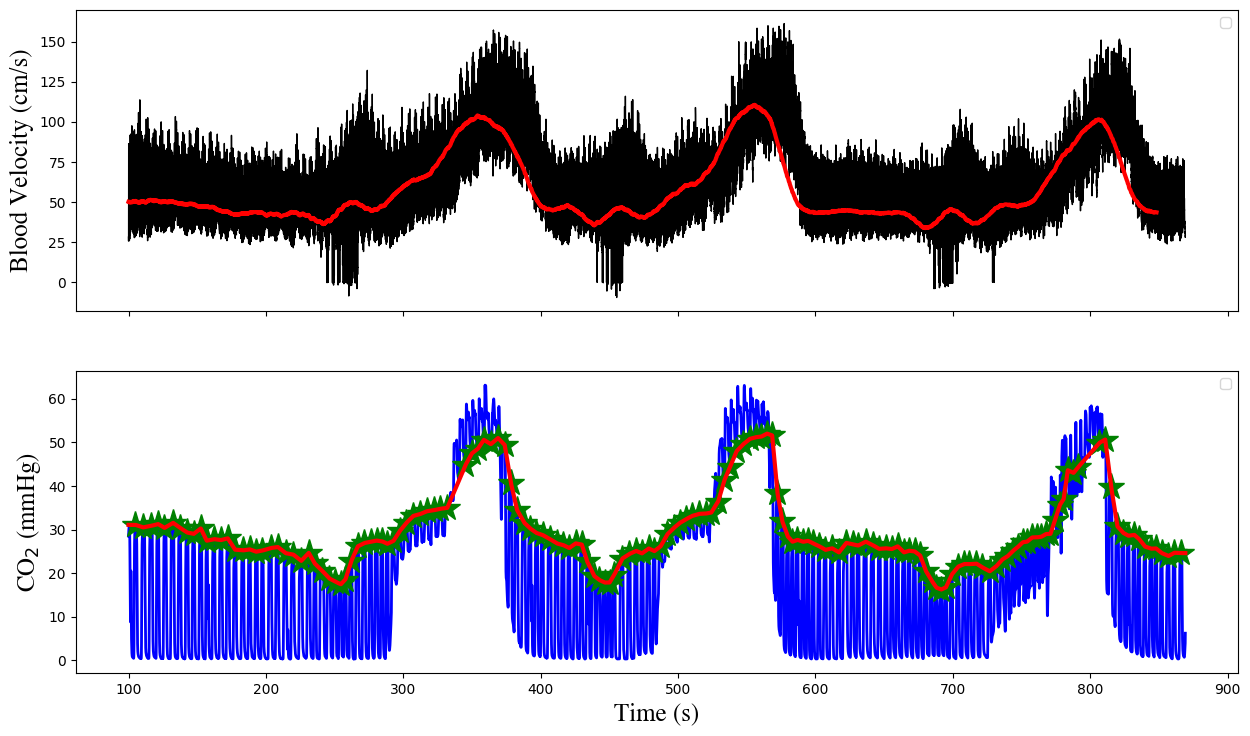

In [ ]:
front_crop = 0

#plot
fig = plt.figure()

#plot parameters
fig.set_figheight(18)
fig.set_figwidth(15)
tfont = {'fontname':'Times'}

#plot TCD MCAv
ax1 = fig.add_subplot(411)
#ax1.set_title("Ramp Protocol", fontsize=18, **tfont)       
ax1.set_ylabel('Blood Velocity (cm/s)', fontsize=18, **tfont)
TCD_th_manshifted[front_crop:].plot(ax=ax1, c="black", lw=1)
ax1.legend(['MCAvmax', 'MCAvmin', 'MCAvmean'], fontsize=10)
# overlay rolling mean on TCD plot
TCD_rolling_shifted[front_crop:].plot(ax=ax1, c="red", lw=3)
# remove ax1 x axis labels
ax1.set_xticklabels([])

#plot CO2 percentage
ax2 = fig.add_subplot(412)   
ax2.set_ylabel('CO$_{2}$ (mmHg)', fontsize=18, **tfont)
CO2[front_crop:].plot(c="blue", lw=2)
# plot the CO2 peaks
CO2peaks_df[front_crop:].plot(ax=ax2, marker='*',linestyle='None',markersize = 20.0, color = 'g')
ax2.legend(['End-Tidal CO2'], fontsize=10)
# overlay interpolated CO2 on CO2 plot
ax2.plot(TCD_rolling[front_crop:].index, CO2peaks_interp[front_crop:], c="red", lw=3)
ax2.set_xlabel('Time (s)', fontsize=18, **tfont) 
#scale the x axis labels by 5 to convert to ms
ax2.set_xticklabels(np.arange(0, len(CO2peaks_interp), step=100))

# remove legend from all plots
ax1.legend('')
ax2.legend('')

plt.show()

In [65]:
# save a copy of the figure in as a png in the same sample_data folder
fig.savefig(local + 'sample_data/' + sub + '/' + ses + '/' + sub + '_' + ses + '_' + date + '_' + task + '_fulltraces_xcorr.png')

In [66]:
total_time_shift_applied_sec = int(time_shift+man_shift)/sample_rate
print('total_time_shift_applied_sec:', total_time_shift_applied_sec)

total_time_shift_applied_sec: -20.95499999998094


In [ ]:
# save total_time_shift_applied_sec into a csv
print('Subject TCD-:', sub)

csv_time_shift_parameters = local + 'sample_data/' + 'time_shift_log_tcd.csv'
time_shift_parameters = pd.DataFrame({'sub-tcd':[sub],'total_time_shift_applied_sec':[total_time_shift_applied_sec], 'xcorr_shift_sec':[int(time_shift)/200]})
# if the file does not exist, create it
if not os.path.exists(csv_time_shift_parameters):
    time_shift_parameters.to_csv(csv_time_shift_parameters, index=False)
    print('Time shift log saved to new file:', csv_time_shift_parameters)
# if the file exists, append to it
else:
    time_shift_parameters.to_csv(csv_time_shift_parameters, mode='a', header=False, index=False)
    print('Time shift parameter log appended to existing file:', csv_time_shift_parameters)

Subject TCD-: sub-002
Time shift log saved to new file: /Users/ghayes/Desktop/Ramp_PWL/sample_data/time_shift_log_tcd.csv
